In [1]:
# import tarfile

# tar = tarfile.open("tud.tar")
# tar.extractall(path="tud")
# tar.close()

Here we extract the tar folder that contains our dataset.

We import important modules

In [2]:
import os
import torch 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn.functional as F

We use GPU if there is any.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's view two examples of the data we have.

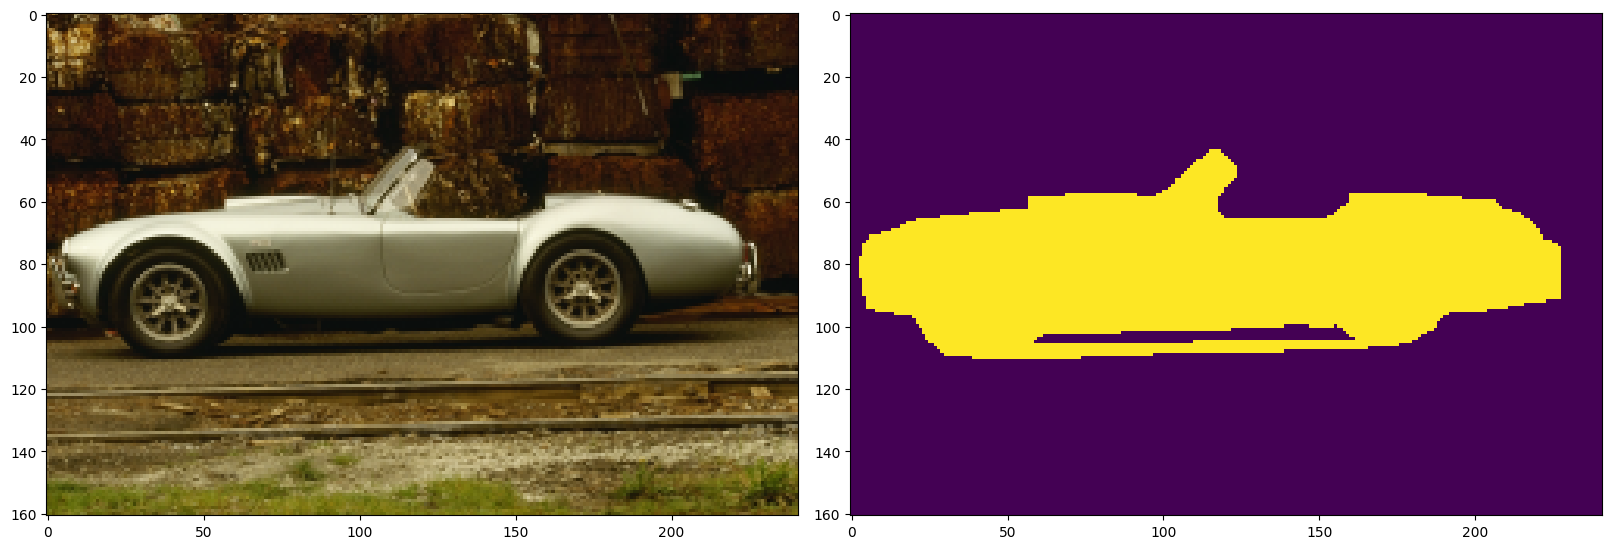

In [4]:
image_name = "29000-sml-lt.png"
label_image_semantic = "./tud/TUDarmstadt/GTMasks/sideviews-cars/"+image_name
original_image = "./tud/TUDarmstadt/PNGImages/sideviews-cars/" + image_name

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

original_image = Image.open(original_image)
original_image = np.asarray(original_image)

axs[0].imshow( original_image)
axs[0].grid(False)

label_image_semantic = Image.open(label_image_semantic)
label_image_semantic = np.asarray(label_image_semantic)

axs[1].imshow(label_image_semantic)
axs[1].grid(False)




In [5]:
label_image_semantic = np.asarray(label_image_semantic)
print("Segmented image",label_image_semantic.shape)

original_image = np.asarray(original_image)
print("original image",original_image.shape)


print(label_image_semantic[100,100], label_image_semantic[0,0])


Segmented image (161, 241)
original image (161, 241, 3)
True False


We can notice that the GTMasks directory contains images that have been segmented into two colors: dark and light color. The light color represents the car, while the dark color represents the background. The PNGImages directory contains the original, unprocessed images. By comparing the images in these two directories, we can see how the segmentation process has separated the car from the background. The pixels representing the car are set to True, while the background is set to False.

In [6]:
cwd = os.getcwd()

relative_path_segmented = "./tud/TUDarmstadt/GTMasks/sideviews-cars/"
relative_path_png = "./tud/TUDarmstadt/PNGImages/sideviews-cars/"
# Get a list of all files in the directory
gtmasks = os.path.join(cwd,relative_path_segmented )
pngs = os.path.join(cwd,relative_path_png )

gtmasks_fileNames = os.listdir(gtmasks)
pngs_fileNames = os.listdir(pngs)
print(len(gtmasks_fileNames) , len(pngs_fileNames))


100 100


In [7]:
#setting constants

IMAGE_SHAPE = (161, 241)
TEST_SIZE = 0.1
VAL_SIZE = 0.15


IMG_PATH = "./tud/TUDarmstadt/PNGImages/sideviews-cars/"
MASK_PATH = "./tud/TUDarmstadt/GTMasks/sideviews-cars/"

# Spliting Data

In [8]:
df = pd.DataFrame({'id': pngs_fileNames}, index = np.arange(0, len(pngs_fileNames)))

X_trainval, X_test = train_test_split(df['id'].values, test_size=TEST_SIZE, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=VAL_SIZE, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  76
Val Size     :  14
Test Size    :  10



# Dataset

Dataset class which will allow us to iterate through our images and masks in a batch. We also apply image augmentation and normalization on our images. The 'len' function returns the length of the dataset, and the 'getitem' function returns a single item from the dataset at a given index. The 'mean' and 'std' parameters are used for normalization, and the 'transform' parameter is used to apply image augmentation.

In [9]:
class ImageDataset(torch.utils.data.Dataset): 
    def __init__(self, img_path, mask_path, X , mean = None , std = None,transform = None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.resize = T.Resize((128, 128))
    
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        t = None 
        img = cv2.imread(self.img_path + self.X[idx] )
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx], cv2.IMREAD_GRAYSCALE)
        
        # if transform, it should be applied on both images
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            # transform to image format to transform the picture
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
            
        if self.transform is None:
            img = Image.fromarray(img)
        
        if self.mean is None:
            t = T.Compose([T.ToTensor()])
        else:
            # normalizing to be able to generalize more
            t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
            
            
        img = t(img)
        mask = torch.from_numpy(mask).long()
        mask = mask.to(torch.float32)
        mask = mask.unsqueeze(0)
        
        return img, mask
# Create the ImageDataset object
dataset = ImageDataset(IMG_PATH, MASK_PATH, X_train)
# Check if the img and mask types are floating point types
for img, mask in dataset:
    assert img.dtype.is_floating_point, f"Img is not a floating point type: {img.dtype}"
    assert mask.dtype.is_floating_point, f"Mask is not a floating point type: {mask.dtype}"
# check if mask have 1 channel
for img, mask in dataset:
    assert 1 == mask.size(0), f"mask does not have 1 channel: 1 != {mask.size(0)}"


Let's calculate the mean and std of the training dataset.

In [10]:
dataset_train = ImageDataset(IMG_PATH,MASK_PATH,X_train)

mean = torch.tensor([0., 0., 0.])
std =  torch.tensor([0., 0., 0.])
n_samples = len(X_train)

for data, _ in dataset_train:
    mean = torch.add(mean ,data.sum(dim=(1,2)) /(data.shape[1]*data.shape[2]))

mean /= (n_samples)
for data, _ in dataset_train:
    std[0] = std[0] + ((data[0] - mean[0]) **2).sum() /(data.shape[1]*data.shape[2])
    std[1] = std[1]+ ((data[1] - mean[1]) **2).sum()  /(data.shape[1]*data.shape[2])
    std[2] = std[2] +((data[2] - mean[2]) **2).sum()  /(data.shape[1]*data.shape[2])
    
std /= (n_samples)

print("standard Deviation :",std)
print("Mean               :",mean)

standard Deviation : tensor([0.0626, 0.0586, 0.0617])
Mean               : tensor([0.4169, 0.4095, 0.3720])


## Training

Let's define first the hyperparameters and the training function



### The Hyperparameters

In [18]:
batch_size = 3
lr = 0.0001
num_epochs = 10
shuffle = True
betas = (0.9, 0.999)
eps=1e-08
weight_decay = 0.



### Training Function

In [19]:
def compute_acc(mask, res): 
  diff = abs(res - mask) 
  return diff.mean()
  
def train(model, dataloader, criterion, optimizer, device, num_epochs, val_dataloader=None):
  # Set the model to training mode
  model.train()

  # Initialize variables to track the epoch loss and accuracy
  epoch_loss = 0
  epoch_acc = 0.0

  # Loop over the number of epochs
  for epoch in range(num_epochs):
    # Loop over the data samples in the dataloader
    for data, labels in dataloader:
      # Move data and labels to the device
      data = data.to(device)
      labels = labels.to(device)

      # Zero out the gradients
      optimizer.zero_grad()
      print(labels.max())

      # Forward pass
      outputs = model(data)
      loss = criterion( labels,outputs)

      # Compute the accuracy
      acc = compute_acc(outputs, labels)

      # Backward pass and optimization step
      loss.backward()
      optimizer.step()

      # Add the loss and accuracy for this batch to the epoch loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

    # Compute the average loss and accuracy for the epoch
    epoch_loss_avg = epoch_loss/(epoch+1)
    epoch_acc_avg = epoch_acc / ( epoch+1)

    # Print the epoch loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss_avg:.4f}, Accuracy = {epoch_acc_avg:.4f}')

    # Validate the model on the validation set, if provided
    if val_dataloader is not None:
      val_loss, val_acc = validate(model, val_dataloader, criterion, device)
      print(f'Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.4f}')

    


In [20]:
from model import UNET


model = UNET(3,1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

dataset_train = ImageDataset(IMG_PATH,MASK_PATH,X_train)
dataset_val = ImageDataset(IMG_PATH,MASK_PATH,X_val)


In [21]:
for X , _ in dataset_train:
    print(X.shape)
    
# X_train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)
# X_val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=True)


torch.Size([3, 190, 253])
torch.Size([3, 197, 262])
torch.Size([3, 224, 299])
torch.Size([3, 102, 292])
torch.Size([3, 178, 237])
torch.Size([3, 238, 317])
torch.Size([3, 162, 243])
torch.Size([3, 183, 244])
torch.Size([3, 201, 268])
torch.Size([3, 224, 299])
torch.Size([3, 183, 244])
torch.Size([3, 186, 248])
torch.Size([3, 151, 201])
torch.Size([3, 189, 252])
torch.Size([3, 146, 260])
torch.Size([3, 179, 238])
torch.Size([3, 181, 241])
torch.Size([3, 227, 302])
torch.Size([3, 218, 291])
torch.Size([3, 188, 251])
torch.Size([3, 165, 248])
torch.Size([3, 191, 254])
torch.Size([3, 179, 238])
torch.Size([3, 179, 239])
torch.Size([3, 170, 227])
torch.Size([3, 194, 259])
torch.Size([3, 287, 383])
torch.Size([3, 186, 248])
torch.Size([3, 208, 277])
torch.Size([3, 193, 257])
torch.Size([3, 182, 273])
torch.Size([3, 238, 317])
torch.Size([3, 166, 249])
torch.Size([3, 170, 227])
torch.Size([3, 199, 265])
torch.Size([3, 169, 253])
torch.Size([3, 260, 346])
torch.Size([3, 206, 275])
torch.Size([

As we have noticed in the data exploration step, the images are of different size. Recall that to use a dataloader we need images of the same size. We will thus need to develop a method to pad these images. We can create a custom collate function for the dataloader that handles the variable-sized images. The collate function is responsible for combining the data samples in a batch and can be customized to handle variable-sized data.

In [22]:
def custom_collate(data):
  # Extract the data and labels from the data samples
  imgs, masks = zip(*data)

  # Find the maximum size for the data samples
  max_size = max([d.shape[-2:] for d in imgs])

  # Pad the smaller data samples with zeros to the maximum size
  img_padded = [pad_to_size(img = img, size = max_size) for img in imgs]
  mask_padded = [pad_to_size(img = mask, size = max_size) for mask in masks]

  # Convert the data samples and labels to tensors
  data_samples_padded = torch.stack(img_padded)
  masks = torch.stack(mask_padded)

  return data_samples_padded, masks



def pad_to_size(img, size):
    img_height, img_width = img.shape[-2:]
    
    height_diff = size[0] - img_height
    width_diff = size[1] - img_width

    img = F.pad(img, (0, width_diff, 0, height_diff))

    return img


dataloader = DataLoader(dataset_train, batch_size=20, collate_fn=custom_collate)

for data , _ in dataloader:
    print(data.shape)


torch.Size([20, 3, 238, 317])
torch.Size([20, 3, 287, 383])
torch.Size([20, 3, 287, 383])
torch.Size([16, 3, 258, 344])


As we can see now we can use dataloader, with custumized batch size. 

## Test with 1 image

In [23]:
from model import UNET

model = UNET(3,1)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss() 
 
dataset_1 = ImageDataset(IMG_PATH,MASK_PATH,[df['id'].values[1]])
dataloader_1 = DataLoader(dataset_1, batch_size=batch_size, collate_fn=custom_collate)

train(model, dataloader_1, criterion, optimizer, device, 30)


Epoch 1/30: Loss = 52.2131, Accuracy = 47.2134
Epoch 2/30: Loss = 42.4336, Accuracy = 47.1571
Epoch 3/30: Loss = 34.4330, Accuracy = 47.1247
Epoch 4/30: Loss = 27.1332, Accuracy = 47.1033
Epoch 5/30: Loss = 20.2652, Accuracy = 47.0888
Epoch 6/30: Loss = 13.7530, Accuracy = 47.0786
Epoch 7/30: Loss = 7.5772, Accuracy = 47.0713
Epoch 8/30: Loss = 1.6885, Accuracy = 47.0656
Epoch 9/30: Loss = -3.9598, Accuracy = 47.0611
Epoch 10/30: Loss = -9.3859, Accuracy = 47.0572
Epoch 11/30: Loss = -14.6043, Accuracy = 47.0538
Epoch 12/30: Loss = -19.6319, Accuracy = 47.0503
Epoch 13/30: Loss = -24.4794, Accuracy = 47.0468
Epoch 14/30: Loss = -29.1636, Accuracy = 47.0428
Epoch 15/30: Loss = -33.6848, Accuracy = 47.0384
Epoch 16/30: Loss = -38.0428, Accuracy = 47.0338
Epoch 17/30: Loss = -42.2410, Accuracy = 47.0292
Epoch 18/30: Loss = -46.2779, Accuracy = 47.0251
Epoch 19/30: Loss = -50.1860, Accuracy = 47.0206
Epoch 20/30: Loss = -53.9683, Accuracy = 47.0162
Epoch 21/30: Loss = -57.6325, Accuracy = 

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


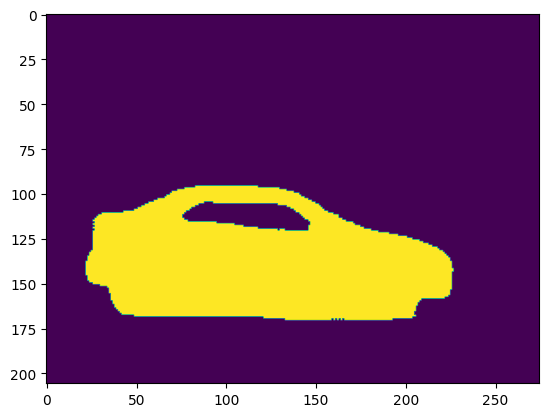

In [24]:
img,msk =dataset_1[0]

res = model(img.unsqueeze(0))
res = (res.reshape(206, 275)) > 0.5
print(res)

plt.imshow(res)
# plt.imshow(msk.reshape(206, 275))